# Task 1: Rating Prediction via Prompting
This notebook implements three different prompting approaches (Zero-shot, Few-shot, Role-based) to classify Yelp reviews into 1-5 star ratings using the Gemini API.

## Approaches
1. **Zero-shot**: Direct classification without examples.
2. **Few-shot**: Classification with 3 static examples.
3. **Role-based**: System instruction setting a specific persona.

## Setup
Ensure you have a `.env` file with `GEMINI_API_KEY` and the `yelp_reviews.csv` dataset in the root directory.

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import time
import json
import pandas as pd
from google import genai
from google.genai import types
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()

api_key = os.getenv("GEMINI_API_KEY")
if not api_key:
    print("WARNING: GEMINI_API_KEY not found in environment variables. Please create a .env file.")

# Configure Gemini Client
client = genai.Client(api_key=api_key)

# Using Gemma 3 27b IT as requested
MODEL_ID = "gemma-3-27b-it" 

print(f"Setup complete. Using model: {MODEL_ID}")

Setup complete. Using model: gemma-3-27b-it


In [17]:
# Load Dataset
DATASET_PATH = "yelp.csv"

try:
    # Assuming standard Yelp dataset with 'text' and 'stars' columns
    # If the file is a JSON, use pd.read_json
    if DATASET_PATH.endswith('.csv'):
        df = pd.read_csv(DATASET_PATH)
    elif DATASET_PATH.endswith('.json'):
        df = pd.read_json(DATASET_PATH, lines=True)
    else:
        # Fallback or placeholder if file doesn't exist yet for the user to fill
        print(f"Dataset not found at {DATASET_PATH}. Please upload the file.")
        df = pd.DataFrame(columns=['text', 'stars'])
    
    print(f"Dataset loaded. Shape: {df.shape}")
    
    # Preprocessing: Keep only relevant columns and drop NaNs
    # Adjust column names based on actual dataset structure
    # Common columns: 'text', 'stars'
    cols_to_keep = ['text', 'stars']
    existing_cols = [c for c in cols_to_keep if c in df.columns]
    
    if len(existing_cols) == 2:
        df = df[existing_cols].dropna()
        
        # Sampling ~200 rows
        # We try to balance the classes if possible, but for simplicity we sample randomly first
        # Or we can do a stratified sample
        sample_size = 200
        if len(df) > sample_size:
            sampled_df = df.groupby('stars', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size // 5))).sample(n=sample_size, random_state=42).reset_index(drop=True)
        else:
            sampled_df = df.copy()
            
        print(f"Sampled Dataset Shape: {sampled_df.shape}")
        print(sampled_df['stars'].value_counts())
    else:
        print(f"Required columns {cols_to_keep} not found. Available: {df.columns}")

except Exception as e:
    print(f"Error loading data: {e}")
    # Create a dummy dataframe for code testing purposes if file is missing
    sampled_df = pd.DataFrame({
        'text': ['Great food!', 'Terrible service.', 'It was okay.'],
        'stars': [5, 1, 3]
    })
    print("Created dummy dataset for testing.")

Dataset loaded. Shape: (10000, 10)
Sampled Dataset Shape: (200, 2)
stars
3    40
1    40
4    40
2    40
5    40
Name: count, dtype: int64


In [26]:
# Helper Function for Gemini API
def get_gemini_response(prompt, system_instruction=None, model=MODEL_ID):
    """
    Sends a prompt to the Gemini model.
    Handles JSON parsing manually since Gemma 3 may not support 'response_mime_type="application/json"' native mode yet.
    """
    max_retries = 6
    base_wait = 5
    
    # Append explicit JSON instruction to prompt since we can't enforce it via config for all models
    json_instruction = """
    \nIMPORTANT: Return ONLY a valid JSON object in the following format:
    {
        "predicted_stars": <integer>,
        "explanation": "<string>"
    }
    Do not output any markdown formatting like ```json ... ```. Just the raw JSON.
    """
    full_prompt = prompt + json_instruction
    
    for attempt in range(max_retries):
        try:
            # Removed response_mime_type="application/json" config which causes 400 on Gemma
            config = types.GenerateContentConfig(
                temperature=0.2 # Low temperature for more deterministic JSON
            )
            
            response = client.models.generate_content(
                model=model,
                contents=full_prompt,
                config=config
            )
            
            # Using Gemma 3 27b - Free tier allows ~30 RPM (2s per request)
            time.sleep(3) 
            
            # Manual Text Cleaning & Parsing
            text = response.text.strip()
            # Remove potential markdown code blocks
            if text.startswith("```json"):
                text = text[7:]
            if text.startswith("```"):
                text = text[3:]
            if text.endswith("```"):
                text = text[:-3]
            
            return json.loads(text.strip())
            
        except json.JSONDecodeError:
            print(f"\nJSON Decode Error on attempt {attempt+1}. Response was: {response.text[:50]}...")
            time.sleep(2) # Short wait before retry
        except Exception as e:
            error_str = str(e)
            if "429" in error_str or "503" in error_str:
                wait_time = base_wait * (1.5 ** attempt) # Exponential backoff
                print(f"\nAPI Quota/Error (Attempt {attempt+1}/{max_retries}). Retrying in {wait_time:.1f}s...")
                time.sleep(wait_time)
            elif "404" in error_str or "400" in error_str:
                 # 400 might be specific model param issues, but we updated config so it should pass now
                print(f"API Error {e}")
                return None
            else:
                print(f"API Error: {e}")
                return None
    
    print("\nMax retries exceeded.")
    return None

print("Helper function updated for manual JSON parsing (Gemma compatibility).")

Helper function updated for manual JSON parsing (Gemma compatibility).


In [29]:
# Approach 1: Zero-Shot Prompting
def predict_zero_shot(review_text):
    prompt = f"""
    Classify the following Yelp review into a 1-5 star rating.
    
    Review: "{review_text}"
    
    Return the rating and a brief explanation.
    """
    return get_gemini_response(prompt)

# Test on one example
test_review = sampled_df.iloc[0]['text']
print(f"Review: {test_review}")
print("Zero-Shot Prediction:", predict_zero_shot(test_review))

Review: I went here this morning for breakfast with the BF to use our living social deal. We had been to black bear before about 6 years ago in glendale and then again maybe 4 years ago up in Washington state. The last time we went, we were not terribly thrilled with the place. Anyway, we decided to give them another shot and it was pretty decent. I had the shasta scramble, which has avocado, onion, bell pepper, and spinach. This was good, it was not the most flavorful scramble I have ever had, but the veggies were fresh and I liked that this was an option on their menu because most places only have one veggie scramble and it has tons of veggies thrown in with no reason for those veg to go together...anyway, the breakfast came with a ton of country potatoes which I liked more than the typical hash brown. The BF got the one biscuit and gravy breakfast and he said it was alright, not the best ever, but not bad. I thought breakfast here was better than Denny's or Ihop, but clearly not as 

In [30]:
# Approach 2: Few-Shot Prompting
def predict_few_shot(review_text):
    prompt = f"""
    Classify the Yelp review into a 1-5 star rating based on the examples below.

    Example 1:
    Review: "The service was absolutely terrible. I waited 30 minutes for water."
    Output: {{ "predicted_stars": 1, "explanation": "Negative sentiment regarding service delay." }}

    Example 2:
    Review: "Food was okay, but a bit overpriced for the portion size."
    Output: {{ "predicted_stars": 3, "explanation": "Mixed sentiment; quality acceptable but poor value." }}

    Example 3:
    Review: "Amazing experience! The steak was cooked perfectly."
    Output: {{ "predicted_stars": 5, "explanation": "Highly positive feedback on food quality." }}

    Target Review:
    Review: "{review_text}"
    
    Return the rating and a brief explanation in JSON.
    """
    return get_gemini_response(prompt)

print("Few-Shot Prediction:", predict_few_shot(test_review))

Few-Shot Prediction: {'predicted_stars': 3, 'explanation': "Overall positive but with several caveats. The reviewer found the food 'decent' and better than some chains, but not as good as local favorites. Service was good despite some odd interactions. Mixed feelings about portion sizes."}


In [31]:
# Approach 3: Role-Based Prompting
def predict_role_based(review_text):
    # We can pass system instructions via the config or just part of the prompt.
    # The SDK supports system_instruction at the client/model level usually,
    # but here we can just prepend it or use the 'system_instruction' parameter if supported by 'generate_content' directly 
    # (Update: modern SDKs often require it at model instantiation or as a separate arg)
    
    # For simplicity and robustness with the helper, we'll embed it.
    
    sys_instruction = "You are an expert Sentiment Analyst and Food Critic with 20 years of experience. Your job is to accurately infer the star rating of a customer review based on nuanced language, tone, and context."
    
    prompt = f"""
    {sys_instruction}
    
    Analyze this Yelp review:
    "{review_text}"
    
    Provide the star rating (1-5) and your professional reasoning.
    """
    return get_gemini_response(prompt)

print("Role-Based Prediction:", predict_role_based(test_review))

Role-Based Prediction: {'predicted_stars': 3, 'explanation': "This review is overwhelmingly positive-neutral, leaning towards a solid 3 stars. While the reviewer acknowledges past disappointments and doesn't rave about the food, they consistently use words like 'decent,' 'good,' and 'alright.' They explicitly state it was 'better than Denny's or Ihop,' which sets a baseline of acceptability. The criticisms are minor – the scramble wasn't *the most* flavorful, the boyfriend found his meal 'alright,' and the waitress's terms of endearment were slightly off-putting. However, these are balanced by praise for fresh vegetables, the country potatoes, good service (despite the nickname issue), and large portions. The concluding statement – 'I would probably come back here for breakfast again sometime' – is a strong indicator of overall satisfaction, even if not enthusiastic. The comparison to higher-rated local spots ('Farmhouse or Liberty Market') positions Black Bear as a step below those, b

In [27]:
# Evaluation Loop
results = []

print("Starting evaluation on sampled dataset...")

for index, row in sampled_df.iterrows():
    text = row['text']
    actual_stars = row['stars']
    
    # Placeholder for results of this row
    row_result = {
        'index': index,
        'actual_stars': actual_stars,
        'zero_shot_pred': None,
        'zero_shot_valid': False,
        'few_shot_pred': None,
        'few_shot_valid': False,
        'role_based_pred': None,
        'role_based_valid': False
    }
    
    print(f"Processing row {index+1}/{len(sampled_df)}...", end='\r')
    
    # 1. Zero Shot
    try:
        res = predict_zero_shot(text)
        if res and 'predicted_stars' in res:
            row_result['zero_shot_pred'] = res['predicted_stars']
            row_result['zero_shot_valid'] = True
    except Exception as e:
        print(f"\nZero-shot error at index {index}: {e}")

    # 2. Few Shot
    try:
        res = predict_few_shot(text)
        if res and 'predicted_stars' in res:
            row_result['few_shot_pred'] = res['predicted_stars']
            row_result['few_shot_valid'] = True
    except Exception as e:
        print(f"\nFew-shot error at index {index}: {e}")

    # 3. Role Based
    try:
        res = predict_role_based(text)
        if res and 'predicted_stars' in res:
            row_result['role_based_pred'] = res['predicted_stars']
            row_result['role_based_valid'] = True
    except Exception as e:
        print(f"\nRole-based error at index {index}: {e}")
    
    results.append(row_result)

results_df = pd.DataFrame(results)
print("\nEvaluation complete.")
results_df.head()

Starting evaluation on sampled dataset...
Processing row 68/200...
API Quota/Error (Attempt 1/6). Retrying in 5.0s...
Processing row 200/200...
Evaluation complete.


,index,actual_stars,zero_shot_pred,zero_shot_valid,few_shot_pred,few_shot_valid,role_based_pred,role_based_valid
0,0,3,3,True,3,True,3,True
1,1,1,1,True,1,True,1,True
2,2,1,1,True,1,True,1,True
3,3,4,4,True,4,True,4,True
4,4,4,5,True,5,True,5,True


### Summary Results
     Approach  Accuracy (%)  JSON Validity (%)
0   Zero-Shot          69.5              100.0
1    Few-Shot          68.0              100.0
2  Role-Based          69.5              100.0


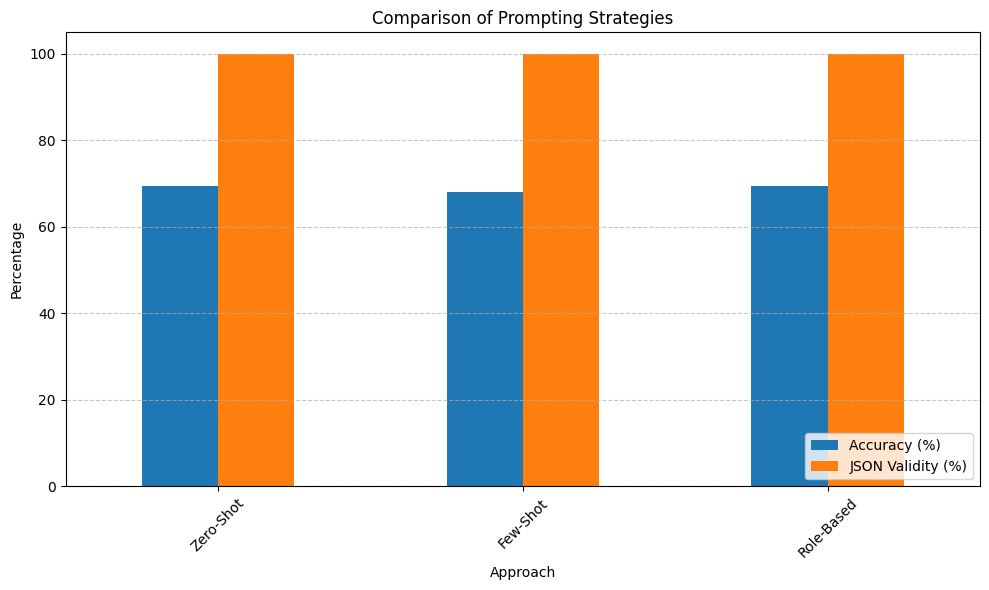

In [28]:
# Metrics Calculation
def calculate_metrics(df, pred_col, valid_col):
    # Filter for valid responses only for accuracy calculation
    valid_df = df[df[valid_col] == True]
    
    validity_rate = df[valid_col].mean() * 100
    accuracy = accuracy_score(valid_df['actual_stars'], valid_df[pred_col]) * 100 if not valid_df.empty else 0
    
    return accuracy, validity_rate

acc_zero, val_zero = calculate_metrics(results_df, 'zero_shot_pred', 'zero_shot_valid')
acc_few, val_few = calculate_metrics(results_df, 'few_shot_pred', 'few_shot_valid')
acc_role, val_role = calculate_metrics(results_df, 'role_based_pred', 'role_based_valid')

summary = pd.DataFrame({
    'Approach': ['Zero-Shot', 'Few-Shot', 'Role-Based'],
    'Accuracy (%)': [acc_zero, acc_few, acc_role],
    'JSON Validity (%)': [val_zero, val_few, val_role]
})

print("### Summary Results")
print(summary)

# Visualizing Results
summary.set_index('Approach')[['Accuracy (%)', 'JSON Validity (%)']].plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Prompting Strategies')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()